<a href="https://colab.research.google.com/github/marcusaxelsson1/Advanced_NN/blob/main/HWA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The first set of problems deal with the Cora dataset[6], which is citation graph of scientific
papers. The nodes (papers) have features given by sparse bag-of-words vector that cor-
respond to 1433 keywords. There are seven categories of papers based on a classification
of the keywords. Out of the 2708 nodes 140 are labeled in the standard training set,
20 in each class. The dataset can be found: https://github.com/kimiyoung/planetoid or
through PyG.
You are welcome to use the Colab Notebook on node classification on the Cora dataset
provided in the PyTorch Geometric documentation. Either modify and run directly in
Google Colab or reuse relevant parts of the code in your own Jupyter notebook or other
environment.


1.   From the Planetoid Cora dataset, extract the number of nodes that are in the training set, validation set, and test set. Discuss briefly the implications for super-
vised versus semi-supervised learning.
2.   Train both a standard dense network using supervised learning and a network
using the convolution from equation 1 using semi-supervised learning.
3. Use t-SNE to visualize the results.
All of this is essentially provided in the Colab notebook referred to above. You are also
welcome to try out varying the depth and width of the network to improve the accuracy.









In [1]:
!pip install torch_geometric
!pip install pyvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.1 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch_geometric.utils as utils
import numpy as np
import networkx as nx
from torch_geometric.nn import global_mean_pool, GraphConv, GATConv, GCNConv, NNConv

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Aquire the dataset
dataset1 = Planetoid(root='/tmp/Cora', name='Cora')

data1 = dataset1[0].to(device)

Processing...
Done!


In [5]:
# Nodes for training, validation, and test sets
train_mask = data1.train_mask.sum().item()
val_mask = data1.val_mask.sum().item()
test_mask = data1.test_mask.sum().item()

print(f'Training set nodes: {train_mask}')
print(f'Validation set nodes: {val_mask}')
print(f'Test set nodes: {test_mask}')

Training set nodes: 140
Validation set nodes: 500
Test set nodes: 1000


# Discussion (supervised vs semisupervised learning)

With only 140 labeled nodes in the training set, we need to use the unlabeled data in a clever way to improve how much the model can learn. This is common in reality as it is difficult or costly to label data. From what I understand it uses the distribution of the data to infer the labels of the unlabeled datapoints by how similar they are to the labeled datapoints.

In [36]:
# Dense NN
# Dense Neural Network
class DenseNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DenseNN, self).__init__()
        self.Linear1 = nn.Linear(input_dim, hidden_dim)
        self.Linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.Linear3 = nn.Linear(hidden_dim, output_dim)
        self.ReLU = nn.ReLU()

    def forward(self, data):
        x = data.x
        x = self.ReLU(self.Linear1(x))
        x = self.ReLU(self.Linear2(x))
        x = self.Linear3(x)
        return F.softmax(x, dim=1)

# Graph Convolutional Network
class ConvNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ConvNet, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.ReLU = nn.ReLU()

    def forward(self, data):
        x, edgeIndex = data.x, data.edge_index
        x = self.ReLU(self.conv1(x, edgeIndex))
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.conv2(x, edgeIndex)
        return F.softmax(x, dim=1)

input_dim = dataset1.num_node_features
hidden_dim = input_dim
output_dim = dataset1.num_classes

dense_model = DenseNN(input_dim, hidden_dim, output_dim).to(device)
gcn_model = ConvNet(input_dim, hidden_dim, output_dim).to(device)

In [37]:
optimizer_dense = optim.Adam(dense_model.parameters(), lr=0.01)
optimizer_gcn = optim.Adam(gcn_model.parameters(), lr=0.01)
criterion = nn.NLLLoss()

Epoch 1: Trainloss: -0.14298467338085175, ValidationLoss: -0.17366266250610352
Epoch 6: Trainloss: -0.9975844025611877, ValidationLoss: -0.3850220739841461
Epoch 11: Trainloss: -0.9999998807907104, ValidationLoss: -0.3713614344596863
Epoch 16: Trainloss: -1.0, ValidationLoss: -0.35440316796302795
Epoch 1: Trainloss: -0.14408953487873077, ValidationLoss: -0.291273832321167
Epoch 6: Trainloss: -0.9904837608337402, ValidationLoss: -0.7317423820495605
Epoch 11: Trainloss: -0.9997783303260803, ValidationLoss: -0.7549327611923218
Epoch 16: Trainloss: -0.9999997615814209, ValidationLoss: -0.7659303545951843


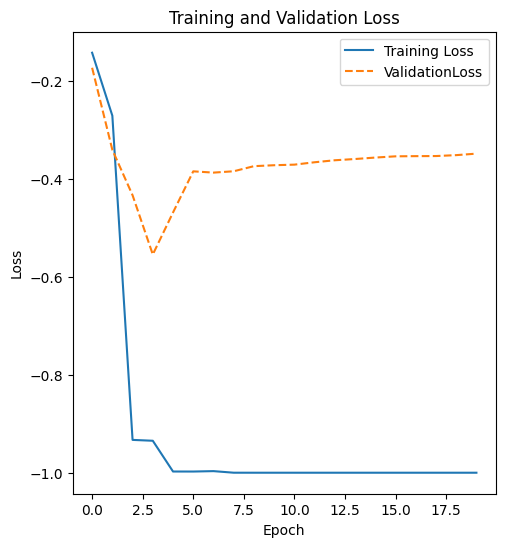

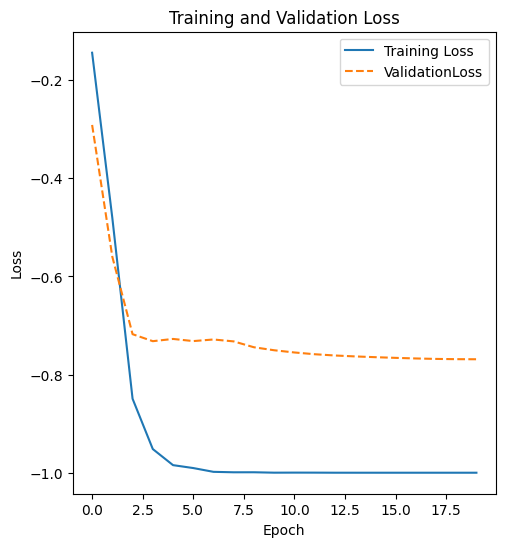

In [38]:
def train_and_validate(model, optimizer, criterion, data, train_mask, val_mask, num_epochs=100, model_name='model'):
    model.to(device)
    data.to(device)
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[train_mask], data.y[train_mask])
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Validation
        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = criterion(out[val_mask], data.y[val_mask])
            val_losses.append(val_loss.item())

            # Check for improvement and save the model if better
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), f'{model_name}_best.pth')
                #print(f'Epoch {epoch+1}: New best validation loss: {best_val_loss}')
            if (epoch % 5 == 0):
              print(f'Epoch {epoch+1}: Trainloss: {train_losses[-1]}, ValidationLoss: {val_losses[-1]}')

    return train_losses, val_losses

# Training and validation
num_epochs = 20
train_losses_dense, val_losses_dense = train_and_validate(dense_model, optimizer_dense, criterion, data1, data1.train_mask, data1.val_mask, num_epochs, 'dense_nn')
train_losses_gcn, val_losses_gcn = train_and_validate(gcn_model, optimizer_gcn, criterion, data1, data1.train_mask, data1.val_mask, num_epochs, 'gcn_model')

# Plotting results
def plot_training(train_losses, val_losses, metric):
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label='Training ' + metric)
  plt.plot(val_losses, label='Validation' + metric, linestyle='--')
  plt.title('Training and Validation ' + metric)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

plot_training(train_losses_dense, val_losses_dense, "Loss")
plot_training(train_losses_gcn, val_losses_gcn, "Loss")




In [9]:
dense_model.load_state_dict(torch.load("dense_nn_best.pth"))
gcn_model.load_state_dict(torch.load("gcn_model_best.pth"))

<All keys matched successfully>

In [10]:
def TSNE_visualize(model, data):
  model.eval()
  with torch.no_grad():
      out = model(data)  # Get the model outputs

  # Use t-SNE to reduce dimensionality
  tsne = TSNE(n_components=2, random_state=42)
  reduced = tsne.fit_transform(out.cpu().detach().numpy())  # Make sure the data is on CPU

  # Plot t-SNE
  plt.figure(figsize=(8, 8))
  scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=data.y.cpu().numpy(), cmap='viridis', alpha=0.6)
  plt.colorbar(scatter)
  plt.title('t-SNE Visualization of Node Embeddings')
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')
  plt.show()

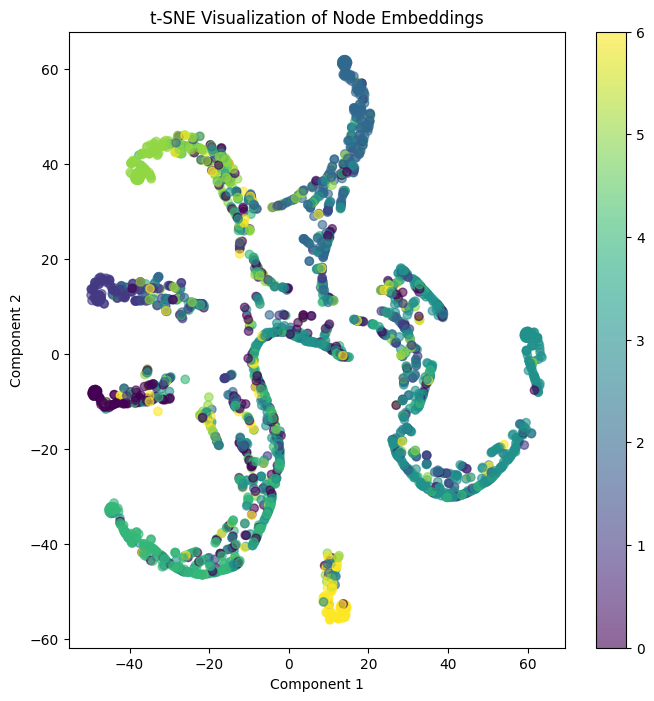

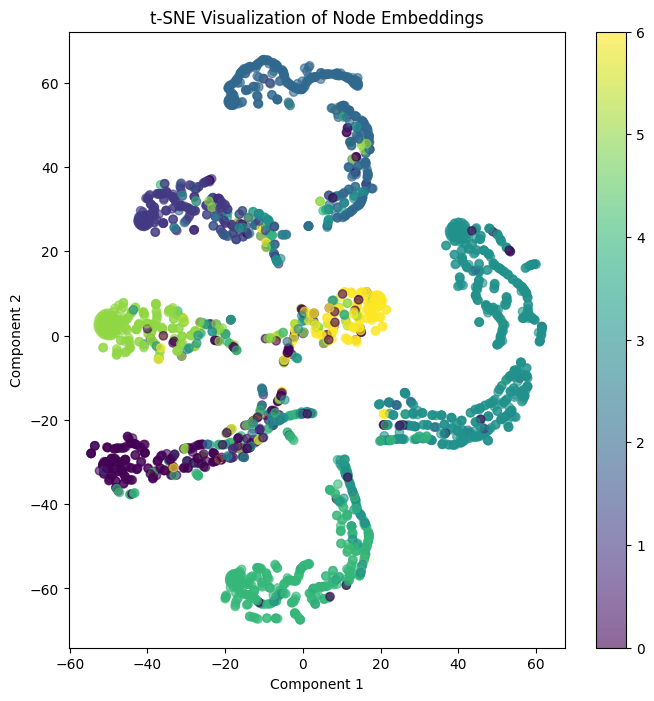

In [11]:
TSNE_visualize(dense_model, data1)
TSNE_visualize(gcn_model, data1)

# **PART 2**

In [12]:
# Get the data from Google Drive
from google.colab import drive
drive.mount('/content/drive')
dataset = torch.load('/content/drive/My Drive/Skola/Avancerade NN/HWA/graph_data_decoding_2024.pt')

Mounted at /content/drive


### Investigating the data a bit

In [13]:
print(f'Number of graphs in the dataset: {len(dataset)}')

print(f'#########################################')
print(f"Let's look at a specific graph! Lets pick graph nr: 7.")
ex_data = dataset[7]
print()
print(f' Print the data: {ex_data}')
print()
print(f'Number of nodes: {ex_data.num_nodes}')
print(f'Number of edges: {ex_data.num_edges}')
print(f'Average node degree: {ex_data.num_edges / ex_data.num_nodes:.2f}')
print(f'Has isolated nodes: {ex_data.has_isolated_nodes()}')
print(f'Has self-loops: {ex_data.has_self_loops()}')
print(f'Is undirected: {ex_data.is_undirected()}')
print(f'Number of node features: {ex_data.num_node_features}')

Number of graphs in the dataset: 1000000
#########################################
Let's look at a specific graph! Lets pick graph nr: 7.

 Print the data: Data(x=[8, 4], edge_index=[2, 52], edge_attr=[52, 1], y=[1, 2])

Number of nodes: 8
Number of edges: 52
Average node degree: 6.50
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Number of node features: 4


In [14]:
label = ex_data.y
print(label)

label_X = label[:,0]
label_Z = label[:,1]
print(label_X, label_Z)

tensor([[0., 0.]])
tensor([0.]) tensor([0.])


In [15]:
edge_index = ex_data.edge_index.t()
edge_index = edge_index.numpy()
feature = ex_data.x.numpy()
edge = ex_data.edge_attr.numpy()
print(edge_index)
print(edge)
print(feature)

[[0 1]
 [0 2]
 [0 3]
 [0 4]
 [0 5]
 [0 6]
 [0 7]
 [1 0]
 [1 2]
 [1 3]
 [1 4]
 [1 5]
 [1 6]
 [2 0]
 [2 1]
 [2 3]
 [2 5]
 [2 6]
 [2 7]
 [3 0]
 [3 1]
 [3 2]
 [3 4]
 [3 5]
 [3 6]
 [3 7]
 [4 0]
 [4 1]
 [4 3]
 [4 5]
 [4 6]
 [4 7]
 [5 0]
 [5 1]
 [5 2]
 [5 3]
 [5 4]
 [5 6]
 [5 7]
 [6 0]
 [6 1]
 [6 2]
 [6 3]
 [6 4]
 [6 5]
 [6 7]
 [7 0]
 [7 2]
 [7 3]
 [7 4]
 [7 5]
 [7 6]]
[[1.        ]
 [1.        ]
 [1.        ]
 [0.0625    ]
 [0.11111111]
 [0.11111111]
 [0.0625    ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.11111111]
 [0.25      ]
 [0.11111111]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.11111111]
 [0.25      ]
 [0.11111111]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.11111111]
 [0.25      ]
 [0.25      ]
 [0.11111111]
 [0.0625    ]
 [0.11111111]
 [0.11111111]
 [1.        ]
 [0.11111111]
 [0.0625    ]
 [0.11111111]
 [0.25      ]
 [0.11111111]
 [0.25      ]
 [1.        ]
 [0.25      ]
 [0.11111111]
 [0.11111111]
 [0.11111111]
 [0.25      ]
 [0.25      ]
 [0.11111111]
 [0.25      ]
 [1. 

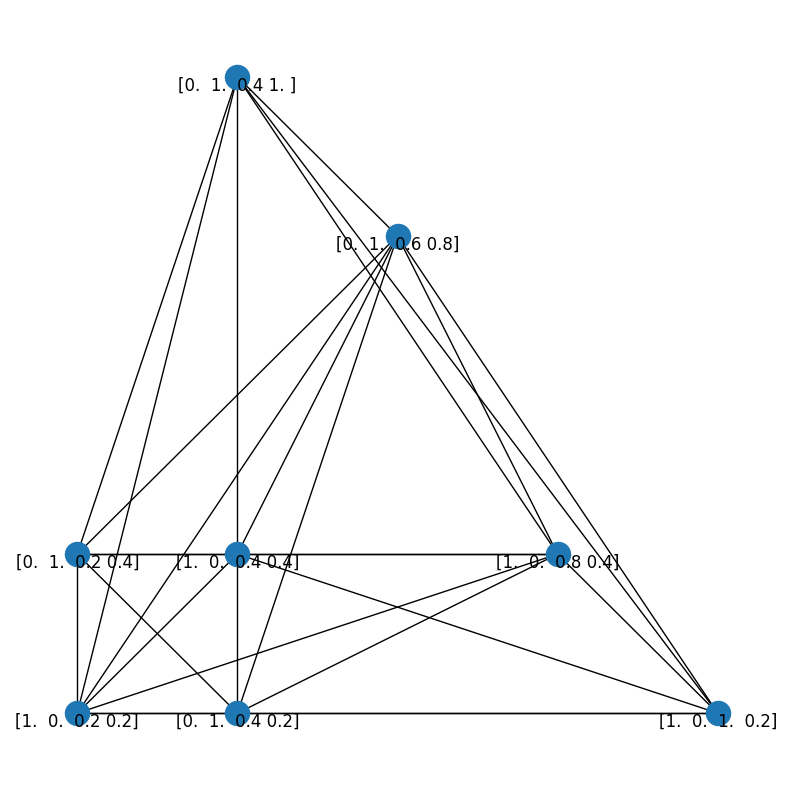

In [16]:
def plot_graph(graph):
  g = utils.to_networkx(graph, to_undirected=True)
  positions = {}
  label_positions = {}
  node_labels = {}
  edge_labels={}
  x = graph.x
  for i in range(x.shape[0]):
      positions[i] = np.array([x[i, 2], x[i, 3]])
      label_positions[i] = np.array([x[i, 2], x[i, 3]])
      node_labels[i] = np.array([x[i, 0], x[i, 1], x[i, 2], x[i, 3]])
  for i in range(edge_index.shape[0]):
      edge_labels[(edge_index[i,0],edge_index[i,1])]=edge[i]

  fig, ax = plt.subplots(figsize = (10, 10))
  nx.draw_networkx(g, ax=ax, pos = positions, labels = node_labels, with_labels = False)
  nx.draw_networkx_labels(g, ax=ax, pos = label_positions, labels = node_labels, verticalalignment= 'top')
  ax.axis('off')

plot_graph(ex_data)

# **Let's build the network**

In [42]:
# Assuming dataset is a PyTorch Dataset
num_samples = len(dataset)
num_train = int(0.95 * num_samples)
num_val = int(0.05 * num_samples)

# Generate shuffled indices
indices = torch.randperm(num_samples)

# Split indices
train_indices = indices[:num_train]
val_indices = indices[num_train:num_train + num_val]


# Create data subsets
train_data = Subset(dataset, train_indices)
val_data = Subset(dataset, val_indices)


# Data loaders
generator = torch.Generator().manual_seed(42)  # For reproducibility
train_loader = DataLoader(train_data, batch_size=100, shuffle=True, generator=generator)
val_loader = DataLoader(val_data, batch_size=100, shuffle=True, generator=generator)

# Print the number of graphs in each dataset
print(f'Number of graphs in training data: {len(train_data)} and validation data: {len(val_data)}')

Number of graphs in training data: 950000 and validation data: 50000


In [43]:
class GNN(nn.Module):
    def __init__(self):
        super().__init__()

        node_feature_size = 4
        edge_feature_size = 1

        self.convs = nn.ModuleList()
        self.edge_mlps = nn.ModuleList()

        layer_sizes = [node_feature_size, 32, 64, 128]

        for i in range(len(layer_sizes) - 1):
            in_channels = layer_sizes[i]
            out_channels = layer_sizes[i+1]
            mlp = nn.Sequential(
                nn.Linear(edge_feature_size, 16),
                nn.ReLU(),
                nn.Linear(16, in_channels * out_channels)  # Ensuring the output matches the expected size
            )
            self.edge_mlps.append(mlp)
            self.convs.append(NNConv(in_channels, out_channels, nn=mlp))

        # Linear layers for classification
        self.xdense1 = nn.Linear(128, 64)
        self.xdense2 = nn.Linear(64, 2)

    def forward(self, x, edge_index, edge_attr, batch):
        # Forward pass through each NNConv layer
        for conv in self.convs:
            x = F.relu(conv(x, edge_index, edge_attr))

        # Global pooling and classifier
        x = global_mean_pool(x, batch) #Mean feature vector across all nodes
        x = F.dropout(x, p=0.1, training=self.training) # Dropout to prevent overfitting
        x = F.relu(self.xdense1(x))
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.xdense2(x)
        return x


In [44]:
class GNN(nn.Module):
    def __init__(self):
        super().__init__()

        node_feature_size = 4
        edge_feature_size = 1
        self.convs = nn.ModuleList()
        self.edge_mlps = nn.ModuleList()
        self.bns = nn.ModuleList()  # Batch normalization layers

        layer_sizes = [node_feature_size, 32, 64, 128]

        for i in range(len(layer_sizes) - 1):
            in_channels = layer_sizes[i]
            out_channels = layer_sizes[i+1]
            mlp = nn.Sequential(
                nn.Linear(edge_feature_size, 16),
                nn.ReLU(),
                nn.Linear(16, in_channels * out_channels)
            )
            self.edge_mlps.append(mlp)
            self.convs.append(NNConv(in_channels, out_channels, nn=mlp))
            self.bns.append(nn.BatchNorm1d(out_channels))  # Adding batch normalization

        # Linear layers for classification
        self.xdense1 = nn.Linear(128, 64)
        self.xdense2 = nn.Linear(64, 2)

    def forward(self, x, edge_index, edge_attr, batch):
        for conv, bn in zip(self.convs, self.bns):  # Apply convolutions and batch normalization
            x = conv(x, edge_index, edge_attr)
            x = bn(x)  # Apply batch normalization
            x = F.relu(x)  # Using ReLU activation function

        x = global_mean_pool(x, batch)  # Global mean pooling
        x = F.dropout(x, p=0.1, training=self.training)
        x = F.relu(self.xdense1(x))
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.xdense2(x)
        return x

In [45]:
import torch
from tqdm import tqdm

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, n_epochs, device='cpu'):
    # This dictionary will store the losses and accuracies for each epoch
    metrics = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': []
    }

    for epoch in range(n_epochs):  # Loop over the number of epochs
        model.train()  # Set the model to training mode
        total_train_correct = 0
        total_train_labels = 0
        total_train_loss = 0

        for data in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            data.x = data.x.to(device)
            data.edge_index = data.edge_index.to(device)
            data.edge_attr = data.edge_attr.to(device)
            data.batch = data.batch.to(device)
            data.y = data.y.to(device)

            optimizer.zero_grad()  # Clear previous gradients
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = criterion(out, data.y)
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            total_train_loss += loss.item() * data.y.size(0)
            prediction = torch.sigmoid(out).round().int()
            correct = (prediction == data.y).all(dim=1)
            total_train_correct += correct.sum().item()
            total_train_labels += data.y.size(0)

        train_accuracy = total_train_correct / total_train_labels
        train_loss = total_train_loss / total_train_labels
        metrics['train_accuracy'].append(train_accuracy)
        metrics['train_loss'].append(train_loss)

        # Set the model to evaluation mode for validation
        model.eval()
        total_val_correct = 0
        total_val_labels = 0
        total_val_loss = 0

        with torch.no_grad():
            for data in tqdm(val_loader, desc=f"Validating Epoch {epoch+1}"):
                data.x = data.x.to(device)
                data.edge_index = data.edge_index.to(device)
                data.edge_attr = data.edge_attr.to(device)
                data.batch = data.batch.to(device)
                data.y = data.y.to(device)

                out = model(data.x, data.edge_index, data.edge_attr, data.batch)
                loss = criterion(out, data.y)
                total_val_loss += loss.item() * data.y.size(0)
                prediction = torch.sigmoid(out).round().int()
                correct = (prediction == data.y).all(dim=1)
                total_val_correct += correct.sum().item()
                total_val_labels += data.y.size(0)

        val_accuracy = total_val_correct / total_val_labels
        val_loss = total_val_loss / total_val_labels

        print(f'Traning Loss: {train_loss}, Validation Loss: {val_loss}')
        print(f'Traning Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}')

        metrics['val_accuracy'].append(val_accuracy)
        metrics['val_loss'].append(val_loss)

    return metrics


In [46]:
modelGCN = GNN().to(device)
n_epochs = 15
learning_rate = 0.001
optimizer = torch.optim.Adam(modelGCN.parameters(), lr=learning_rate)
criterion = torch.nn.BCEWithLogitsLoss()

metrics = train_and_validate(model=modelGCN, train_loader=train_loader, val_loader=val_loader, criterion=criterion, optimizer=optimizer, n_epochs=n_epochs, device=device)



Validating Epoch 1: 100%|██████████| 500/500 [00:03<00:00, 140.03it/s]


Traning Loss: 0.06943965185080704, Validation Loss: 0.04277650135103613
Traning Accuracy: 0.9473863157894736, Validation Accuracy: 0.9706


Validating Epoch 2: 100%|██████████| 500/500 [00:03<00:00, 133.21it/s]


Traning Loss: 0.04306381984564819, Validation Loss: 0.0359530414827168
Traning Accuracy: 0.97016, Validation Accuracy: 0.9747


Validating Epoch 3: 100%|██████████| 500/500 [00:03<00:00, 142.92it/s]


Traning Loss: 0.0380609129903789, Validation Loss: 0.03472277610655874
Traning Accuracy: 0.9738694736842105, Validation Accuracy: 0.97586


Validating Epoch 4: 100%|██████████| 500/500 [00:03<00:00, 135.33it/s]


Traning Loss: 0.03566511219399246, Validation Loss: 0.03172032694751397
Traning Accuracy: 0.9756305263157895, Validation Accuracy: 0.97806


Validating Epoch 5: 100%|██████████| 500/500 [00:03<00:00, 145.41it/s]


Traning Loss: 0.03391226239517135, Validation Loss: 0.031558454100042585
Traning Accuracy: 0.9768978947368421, Validation Accuracy: 0.97836


Validating Epoch 6: 100%|██████████| 500/500 [00:03<00:00, 129.92it/s]


Traning Loss: 0.032706499858318194, Validation Loss: 0.03080568804196082
Traning Accuracy: 0.9777947368421053, Validation Accuracy: 0.97882


Validating Epoch 7: 100%|██████████| 500/500 [00:03<00:00, 137.06it/s]


Traning Loss: 0.03181571803496856, Validation Loss: 0.0305435586925596
Traning Accuracy: 0.9783936842105263, Validation Accuracy: 0.97916


Validating Epoch 8: 100%|██████████| 500/500 [00:03<00:00, 144.27it/s]


Traning Loss: 0.031099885819724907, Validation Loss: 0.029384977247565985
Traning Accuracy: 0.9788526315789474, Validation Accuracy: 0.98042


Validating Epoch 9: 100%|██████████| 500/500 [00:03<00:00, 125.28it/s]


Traning Loss: 0.0305175661918168, Validation Loss: 0.028651968288701028
Traning Accuracy: 0.979178947368421, Validation Accuracy: 0.98068


Validating Epoch 10: 100%|██████████| 500/500 [00:03<00:00, 142.89it/s]


Traning Loss: 0.030053839862628495, Validation Loss: 0.02863191993627697
Traning Accuracy: 0.9796231578947369, Validation Accuracy: 0.98104


Validating Epoch 11: 100%|██████████| 500/500 [00:04<00:00, 116.15it/s]


Traning Loss: 0.02950662278034724, Validation Loss: 0.029236558602191508
Traning Accuracy: 0.9799336842105263, Validation Accuracy: 0.9802


Validating Epoch 12: 100%|██████████| 500/500 [00:03<00:00, 142.56it/s]


Traning Loss: 0.02912113866761425, Validation Loss: 0.027865246636793017
Traning Accuracy: 0.9802578947368421, Validation Accuracy: 0.9814


Validating Epoch 13: 100%|██████████| 500/500 [00:04<00:00, 106.42it/s]


Traning Loss: 0.028867747285550364, Validation Loss: 0.02732910821447149
Traning Accuracy: 0.9805242105263158, Validation Accuracy: 0.98174


Validating Epoch 14: 100%|██████████| 500/500 [00:03<00:00, 141.27it/s]


Traning Loss: 0.028462288489369186, Validation Loss: 0.02761287530278787
Traning Accuracy: 0.9808, Validation Accuracy: 0.98106


Validating Epoch 15: 100%|██████████| 500/500 [00:03<00:00, 135.04it/s]

Traning Loss: 0.028185976321269807, Validation Loss: 0.0272238045996055
Traning Accuracy: 0.980981052631579, Validation Accuracy: 0.98174


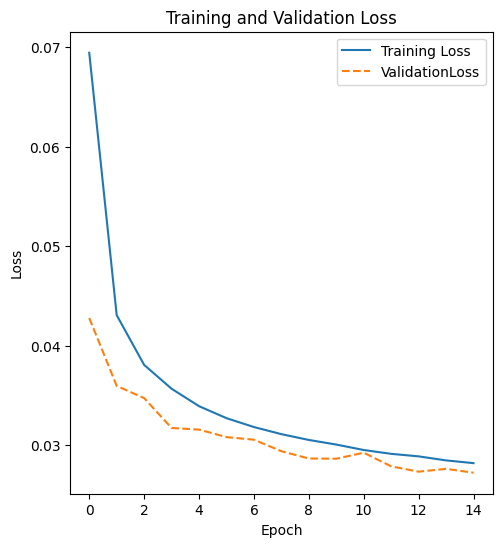

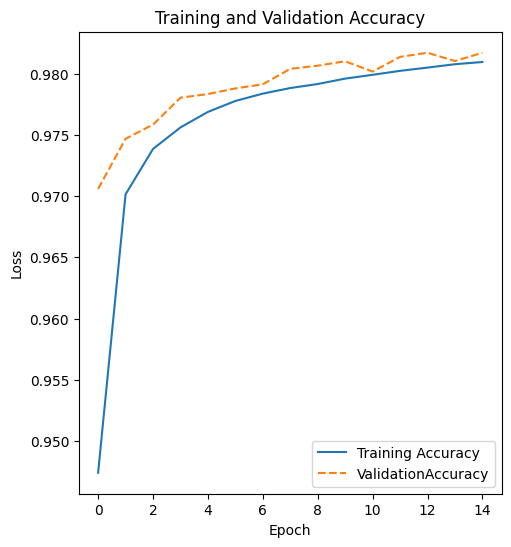

In [47]:
plot_training(metrics["train_loss"], metrics["val_loss"], "Loss")
plot_training(metrics["train_accuracy"], metrics["val_accuracy"], "Accuracy")
print(f'Last Validation Accuracy: {metrics["val_accuracy"][-1]}')